In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

In [2]:
# real (and unknown) parameter
real_mu = 0.8

# possible range of values for mu
mu_support = np.r_[-10,10]

# An observation

In [3]:
#x = Model(real_mu).rvs(1)[0]
# a very extreme (low probability) observation
x = 2

# MCMC with Tensorflow

MCMC allows us to sample the posterior **without** computing the normalization constant.

observe:

- the `log_likelihood` function below, implementing our model.
- the `log_prior` uniform uninformative prior.
- the `unnormalized_log_posterior` aggregation function below is the only input to the Hamiltonian Montecarlo sampler.




In [4]:
log_likelihood = lambda mu: tfd.Normal(loc=mu, scale=1).log_prob(x)
log_prior      = lambda mu: tfd.Normal(loc=-2, scale=3).log_prob(mu)

In [11]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

def sample(x):
    num_burnin_steps = 5000
    num_results = 20000
        
    unnormalized_log_posterior = lambda mu: log_likelihood(mu) + log_prior(mu)    

    initial_chain_state = [
         tf.ones([], dtype=tf.float32, name="init_mu"),
    ]

    step_size = 1

    kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_posterior,
                num_leapfrog_steps=2,
                step_size=step_size,
                state_gradients_are_stopped=True
    )
    
    [
        posterior_mu
    ], kernel_results = graph_sample_chain(
                num_results=num_results,
                num_burnin_steps=num_burnin_steps,
                current_state=initial_chain_state,
                kernel = kernel
        )

    return posterior_mu

In [12]:
posterior_mu = sample(x).numpy()

/opt/anaconda/envs/p39/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


observe that, as we are sampling, we do not have an analytical expression for the PDF

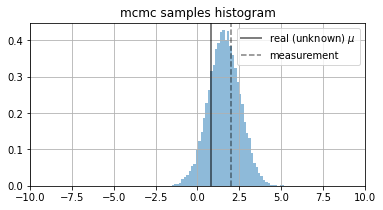

In [13]:
for ax,i in subplots(1, usizex=6):
    plt.hist(posterior_mu, density=True, bins=50, alpha=.5);
    plt.axvline(real_mu, color="black", label=r"real (unknown) $\mu$", alpha=.5, lw=2)
    plt.axvline(x, color="black", label=r"measurement", alpha=.5, ls="--")
    plt.title("mcmc samples histogram")
    plt.grid(); plt.legend();

    plt.xlim(*mu_support)

In [14]:
posterior_mu.mean(), posterior_mu.std()

(1.593746, 0.9423391)